In [224]:
'''
This module contains all functions relating to the cleaning, exploration and feature engineering of structured data sets; mostly in pandas format


install the anaconda python distribution to be able to use numpy, pandas, matplotlib, seaborn, scipy, sklearn and datetime

use pip install for category_encoders 
'''

##pip install category_encoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import *
from IPython.display import display
from collections import Counter
import scipy.stats as sp
import datetime as dt

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [196]:
def get_cat_feats(data=None):
    '''
    Returns the categorical features in a data set
    Parameters:
    -----------
        data: DataFrame or named Series 
    Returns:
    -------
        List
            A list of all the categorical features in a dataset.
    it is used as a helper function for most of the functions to get categorical variables
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    cat_features = data.select_dtypes(include=['object']).columns

    return list(cat_features)

In [197]:
def get_num_feats(data=None):
    '''
    Returns the numerical features in a data set
    Parameters:
    -----------
        data: DataFrame or named Series 
    Returns:
    -------
        List:
            A list of all the numerical features in a dataset.
    it is used as a helper function for most of the functions to get categorical variables
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    num_features = data.select_dtypes(exclude=['object', 'datetime64']).columns

    return list(num_features)

In [198]:
def get_unique_counts(data=None):
    '''
    Gets the unique count of categorical features in a data set.
    Parameters
    -----------
        data: DataFrame or named Series 
    Returns
    -------
        DataFrame or Series
            Unique value counts of the features in a dataset.
    it is used as a helper function in the describe function to get the count of unique values in the columns 
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    features = get_cat_feats(data)
    temp_len = []

    for feature in features:
        temp_len.append(len(data[feature].unique()))
        
    df = list(zip(features, temp_len))
    df = pd.DataFrame(df, columns=['Feature', 'Unique Count'])
    df = df.style.bar(subset=['Unique Count'], align='mid')
    return df

In [199]:
def display_missing(data=None, plot=False):
    '''
    Display missing values as a pandas dataframe.
    Parameters
    ----------
        data: DataFrame or named Series
        plot: bool, Default False
            Plots missing values in dataset as a heatmap
    
    Returns
    -------
        Matplotlib Figure:
            Heatmap plot of missing values
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    df = data.isna().sum()
    df = df.reset_index()
    df.columns = ['features', 'missing_counts']

    missing_percent = round((df['missing_counts'] / data.shape[0]) * 100, 1)
    df['missing_percent'] = missing_percent

    if plot:
        plot_missing(data)
        return df
    else:
        return df

In [200]:
def cat_summarizer(data, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Parameters:
    ---------------------------
        dataframe: pandas dataframe
        x: str.
            horizontal axis to plot the labels of categorical data, y would be the count.
        y: str. 
            vertical axis to plot the labels of categorical data, x would be the count.
        hue: str. i
            if you want to compare it another variable (usually the target variable)
        palette: array, list.
            Colour of the plot
    Returns:
    ----------------------
        Quick Stats of the data and also the count plot
        
        it is used in the describe function
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = data[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=data, palette=palette)
    plt.show()

In [201]:
def _space():
    '''it is used in  most functions to add space. this makes result more presentation'''
    print('\n')
def _match_date(data):
    '''
        Return a list of columns that matches the DateTime expression
    '''
    mask = data.sample(20).astype(str).apply(lambda x : x.str.match(r'(\d{2,4}-\d{2}-\d{2,4})+').all())
    return set(data.loc[:, mask].columns)


def display_rows(data,num=2):
    '''
    Displays the required number of rows
    it is used in the describe function
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")

    return data.head(num)

In [202]:
def plot_missing(data=None):
    '''
    Plots the data as a heatmap to show missing values
    Parameters
    ----------
        data: DataFrame, array, or list of arrays.
            The data to plot.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    sns.heatmap(data.isnull(), cbar=True)
    plt.show()

In [203]:
def class_count(data=None, features=None, plot=False, save_fig=False):
    '''
    Displays the number of classes in a categorical feature.
    Parameters:
    
        data: Pandas DataFrame or Series
            Dataset for plotting.
        features: Scalar, array, or list. 
            The categorical features in the dataset, if None, 
            we try to infer the categorical columns from the dataframe.
        plot: bool, Default False.
            Plots the class counts as a barplot
        save_fig: bool, Default False.
            Saves the plot to the current working directory.
    it is used in the describe function
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    if features is None:
        features = get_cat_feats(data)

                        

    for feature in features:
        if data[feature].nunique() > 15:
            print("Unique classes in {} too large".format(feature))
        else:
            print('Class Count for', feature)
            display(pd.DataFrame(data[feature].value_counts()))

    if plot:
        countplot(data, features, save_fig=save_fig)

In [204]:
def get_date_cols(data=None):
    '''
    Returns the Datetime columns in a data set.
    Parameters
    ----------
        data: DataFrame or named Series
            Data set to infer datetime columns from.
        convert: bool, Default True
            Converts the inferred date columns to pandas DateTime type
    Returns:
    -------
        List
         Date column names in the data set
    use in the describe function to set date columns to datetime datatype in utc
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    #Get existing date columns in pandas Datetime64 format
    date_cols = set(data.dtypes[data.dtypes == 'datetime64[ns, UTC]'].index)
    #infer Date columns 
    date_cols = date_cols.union(_match_date(data))
       
    return date_cols

In [264]:
def bivariate_stats(data):
    '''Returns the contingency table and chi2 contingency test result between columns in the dataframe
        
        it is used in the describe function for categorical features analysis 
    
    
    '''
    cat_feats = get_cat_feats(data=data)
    counter = 1
    try:
        while counter<(len(cat_feats)):
            val1 = get_cat_feats(data=datainput)[counter - 1]
            val2 = get_cat_feats(data=datainput)[counter]
            if (data[val1].nunique() > 15) or (data[val2].nunique() > 15):
                print('Number of unique values too large')
            else:
                freqtab = pd.crosstab(data[val1], data[val2])
                print("Frequency table")
                print("============================")
                print(freqtab)
                print("============================")
                chi2, pval, dof, expected = sp.chi2_contingency(freqtab)
                print("ChiSquare test statistic: ",chi2)
                print("p-value: ",pval)
                _space()
            counter= counter+1
    except:
        pass

In [265]:
def bivariate_stats_target(data, target):
    
    '''Returns the contingency table and chi2 contingency test result between columns and the target variable in the dataframe
        
        
        Parameters
    ----------
        data: DataFrame or named Series
            Data set to infer datetime columns from.
        target: the target variable in form of string

        
        it is used in the describe function for categorical features analysis of the relationship between the target variable 
        and other categorical features
    
    
    '''
    cat_feats = get_cat_feats(data=data)
    for i in cat_feats:
        if (data[i].nunique() > 20):
            print('Number of Unique values too large')
        else:
            freqtab = pd.crosstab(data[i], data[target])
            print("Frequency table")
            print("============================")
            print(freqtab)
            print("============================")
            chi2, pval, dof, expected = sp.chi2_contingency(freqtab)
            print("ChiSquare test statistic: ",chi2)
            print("p-value: ",pval)
            _space()

In [266]:
def describe(data=None, name='', date_cols=None, show_categories=False, plot_missing=False, target = None):
    '''
    Calculates statistics and information about a data set. Information displayed are
    shapes, size, number of categorical/numeric/date features, missing values,
    dtypes of objects, correlation analysis, contigency analysis etc.
    Parameters:
    --------------------
        data: Pandas DataFrame
            The data to describe.
        name: str, optional
            The name of the data set passed to the function.
        date_cols: list/series/array
            Date column names in the data set.
        show_categories: bool, default False
            Displays the unique classes and counts in each of the categorical feature in the data set.
        plot_missing: bool, default True
            Plots missing values as a heatmap
        target: the target variable in the dataframe
    Returns:
    -------
        None
        
        This function is stand alone use for quick statistical exploration of the data.
    '''
    
    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    ## Get categorical features
    cat_features = get_cat_feats(data)
    
    #Get numerical features
    num_features = get_num_feats(data)

    print('First five data points')
    display(data.head())
    _space()

    print('Random five data points')
    display(data.sample(5))
    _space()

    print('Last five data points')
    display(data.tail())
    _space()

    print('Shape of {} data set: {}'.format(name, data.shape))
    _space()

    print('Size of {} data set: {}'.format(name, data.size))
    _space()

    print('Data Types')
    print("Note: All Non-numerical features are identified as objects in pandas")
    display(pd.DataFrame(data.dtypes, columns=['Data Type']))
    _space()
    
    date_cols = get_date_cols(data)
    if len(date_cols) is not 0:
        print("Column(s) {} should be in Datetime format. Use the [to_date] function to convert to Pandas Datetime format".format(date_cols))
        _space()

    print('Numerical Features in Data set')
    print(num_features)
    _space()

    print('Categorical Features in Data set')
    display(cat_features)
    _space()

    print('Statistical Description of Columns')
    display(data.describe())
    _space()
    
    print('Description of Categorical Features')
    if cat_features != None:
        display(data.describe(include=[np.object, pd.Categorical]).T)
        _space()
          
    print('Unique class Count of Categorical features')
    display(get_unique_counts(data))
    _space()

    if show_categories:     
        print('Classes in Categorical Columns')
        print("-"*30)
        class_count(data, cat_features)
        _space()

    print('Missing Values in Data')
    display(display_missing(data))
    _space()
  
    print('Pearson Correlation')
    print(data.corr())
    _space()
    
    print('Kendall Correlation')
    print(data.corr(method='kendall'))
    _space()
    
    print('Spearman Correlation')
    print(data.corr(method='spearman'))
    _space()
    
    print('Bivariant Stats between categorical features')
    print(bivariate_stats(data))
    _space()
    if target is not None:
        print('Bivariant Stats between cat feats and target variable')
        print(bivariate_stats_target(data, target))
        _space()
    print('')

In [267]:
describe(data=data, name='', date_cols=None, show_categories=False, plot_missing=False, target = 'product')

First five data points


,product_id,account_id,id_mail_template,id_approved_email,date,geo_country,email_activity_event_type,email_activity_sent_email,content_category,content_message_local,...,call_date,fs_product_id,change_clm,con_size,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat
0,a001t00000JKjL4AAL,0011t00000IByzYAAT,a1n5J000000TYIKQA4,a1t5J000000U3kwQAC,2020-05-13T12:58:17.000Z,RUS,Opened_vod,a1t5J000000U3kwQAC,Safety,Улучшенный профиль польза/риск,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a001t00000JKjL4AAL,0011t00000IByzYAAT,a1n5J000000TYIKQA4,a1t5J000000U3kwQAC,2020-05-13T12:58:17.000Z,RUS,Delivered_vod,a1t5J000000U3kwQAC,Safety,Улучшенный профиль польза/риск,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a001t00000JKjL4AAL,0011t00000IByzYAAT,a1n5J000000TYIKQA4,a1t5J000000gRJfQAM,2020-06-04T14:09:23.000Z,RUS,Opened_vod,a1t5J000000gRJfQAM,Safety,Улучшенный профиль польза/риск,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a001t00000JKjL4AAL,0011t00000IByzYAAT,a1n5J000000TYIKQA4,a1t5J000000gRJfQAM,2020-06-04T14:09:23.000Z,RUS,Delivered_vod,a1t5J000000gRJfQAM,Safety,Улучшенный профиль польза/риск,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a001t00000JKjL4AAL,0011t00000N9Ig7AAF,a1n5J000000gCLyQAM,a1t5J000000gLaBQAU,2020-05-27T13:11:54.000Z,BRA,Delivered_vod,a1t5J000000gLaBQAU,Key Message Category does not apply,Local Key Message does not apply,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Random five data points


,product_id,account_id,id_mail_template,id_approved_email,date,geo_country,email_activity_event_type,email_activity_sent_email,content_category,content_message_local,...,call_date,fs_product_id,change_clm,con_size,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat
25318,a001v00002KP02YAAT,001G000001sGXKgIAO,NaN,NaN,3/6/2020,Belgium,NaN,NaN,Efficacy,Remission rates vs placebo + MTX and ADA + MTX,...,3/6/2020,a001v00002KP02YAAT,CLM,True,BEL,BE,WE&C,WEC,B2@Rheum_Science First_Green,Efficacy@Remission rates vs placebo + MTX and ...
97385,a001v00002KP02YAAT,NaN,NaN,NaN,1/21/2020,United Kingdom,NaN,NaN,Efficacy,Significantly Greater Remission Rate,...,1/21/2020,NaN,CLM,True,GBR,GB,WE&C,WEC,(No segment)@(No segment),Efficacy@Remission rates vs placebo + MTX and ...
114224,a001t00000JKjL4AAL,0016F00001g27NvQAI,NaN,NaN,2/25/2020,Australia,NaN,NaN,Safety,Well-characterised benefit:risk,...,2/25/2020,a001t00000JKjL4AAL,CLM,True,AUS,AU,JAPAC,JAPAC,B2@Blue,Safety@Safety profile: robust trial program wi...
99727,a001v00002KP02YAAT,001G000001t4uBtIAI,NaN,NaN,2/25/2020,Germany,NaN,NaN,(No message),Verschiebe die Grenzen,...,2/25/2020,a001v00002KP02YAAT,CLM,True,DEU,DE,WE&C,WEC,B2@Rheum_Patients First_Blue,(No message)@(No message)@Verschiebe die Grenzen
86130,a001t00000JKjL4AAL,0016F00001laY2bQAE,NaN,NaN,6/4/2020,Brazil,NaN,NaN,NaN,NaN,...,NaN,a001t00000JKjL4AAL,No CLM,True,BRA,BR,LATAM,LATAM,B2@(No segment),(No message)@(No message)@(No message)




Last five data points


,product_id,account_id,id_mail_template,id_approved_email,date,geo_country,email_activity_event_type,email_activity_sent_email,content_category,content_message_local,...,call_date,fs_product_id,change_clm,con_size,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat
168528,a001v00002W6XH7AAN,NaN,NaN,NaN,2/25/2020,Germany,NaN,NaN,Efficacy,RINVOQ+MTX erstmals signifikant hoehere Remiss...,...,2/25/2020,NaN,CLM,True,DEU,DE,WE&C,WEC,(No segment)@(No segment),Efficacy@Remission rates vs placebo + MTX and ...
168529,a001v00002W6XH7AAN,NaN,NaN,NaN,2/19/2020,Germany,NaN,NaN,NaN,NaN,...,NaN,NaN,No CLM,True,DEU,DE,WE&C,WEC,(No segment)@(No segment),(No message)@(No message)@(No message)
168530,a001v00002W6XH7AAN,NaN,NaN,NaN,3/24/2020,Germany,NaN,NaN,NaN,NaN,...,NaN,NaN,No CLM,True,DEU,DE,WE&C,WEC,(No segment)@(No segment),(No message)@(No message)@(No message)
168531,a001v00002W6XH7AAN,NaN,NaN,NaN,2/26/2020,Germany,NaN,NaN,NaN,NaN,...,NaN,NaN,No CLM,True,DEU,DE,WE&C,WEC,(No segment)@(No segment),(No message)@(No message)@(No message)
168532,a001v00002W6XH7AAN,NaN,NaN,NaN,6/17/2020,Germany,NaN,NaN,NaN,NaN,...,NaN,NaN,No CLM,True,DEU,DE,WE&C,WEC,(No segment)@(No segment),(No message)@(No message)@(No message)




Shape of  data set: (226799, 39)


Size of  data set: 8845161


Data Types
Note: All Non-numerical features are identified as objects in pandas


,Data Type
product_id,object
account_id,object
id_mail_template,object
id_approved_email,object
date,object
geo_country,object
email_activity_event_type,object
email_activity_sent_email,object
content_category,object
content_message_local,object




Numerical Features in Data set
['is_clm', 'activity_channel']


Categorical Features in Data set


['product_id',
 'account_id',
 'id_mail_template',
 'id_approved_email',
 'date',
 'geo_country',
 'email_activity_event_type',
 'email_activity_sent_email',
 'content_category',
 'content_message_local',
 'content_message_global',
 'local_key_message_vault_id',
 'global_key_message_vault_id',
 'product',
 'indication',
 'therapeutic_area',
 'segment_quant',
 'segment_qual',
 'touchpoint_channel_clm',
 'measure_source',
 'period_week',
 'period_month',
 'call_id',
 'calls_account_id',
 'channel',
 'key_message_id',
 'id',
 'call_date',
 'fs_product_id',
 'change_clm',
 'con_size',
 'ISO3',
 'ISO',
 'areaAbbvie',
 'geo_area',
 'segment_concat',
 'content_message_concat']



Statistical Description of Columns


,is_clm,activity_channel
count,168533.000000,0.0
mean,0.613138,NaN
std,0.487033,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN
max,1.000000,NaN




Description of Categorical Features


,count,unique,top,freq
product_id,226799,4,a001v00002KP02YAAT,148738
account_id,193639,12195,001G000001VIf5TIAT,1050
id_mail_template,58266,119,a211v000003aNlVAAU,5508
id_approved_email,58266,14191,a2Q1v000008K6C0EAK,1020
date,226634,13397,3/4/2020,2924
geo_country,226798,50,Germany,60334
email_activity_event_type,58104,10,Opened_vod,36414
email_activity_sent_email,58104,14121,a2Q1v000008K6C0EAK,1020
content_category,141816,8,Efficacy,63655
content_message_local,141819,125,RINVOQ+MTX erstmals signifikant hoehere Remiss...,18491




Unique class Count of Categorical features


,Feature,Unique Count
0,product_id,4
1,account_id,12196
2,id_mail_template,120
3,id_approved_email,14192
4,date,13398
5,geo_country,51
6,email_activity_event_type,11
7,email_activity_sent_email,14122
8,content_category,9
9,content_message_local,126




Missing Values in Data


,features,missing_counts,missing_percent
0,product_id,0,0.0
1,account_id,33160,14.6
2,id_mail_template,168533,74.3
3,id_approved_email,168533,74.3
4,date,165,0.1
5,geo_country,1,0.0
6,email_activity_event_type,168695,74.4
7,email_activity_sent_email,168695,74.4
8,content_category,84983,37.5
9,content_message_local,84980,37.5




Pearson Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Kendall Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Spearman Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Bivariant Stats between categorical features
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Frequency table
product                      ABC_Rinvoq_Rheum  Rinvoq_RA  Rinvoq_RA_KAM
glo

Frequency table
product                      ABC_Rinvoq_Rheum  Rinvoq_RA  Rinvoq_RA_KAM
global_key_message_vault_id                                            
V1M000000000101                           707      42505              5
V1M000000000102                            19      10378              3
V1M000000000103                           135       9724              4
V1M000000000104                           172      19962              3
V1M000000000105                           904       5225              3
V1M000000000201                           386      50944              0
V1M000000000303                             0         32              0
V1M000000000305                             0          9              0
V1M000000000306                             0        453              0
V1M000000000401                             0        107              0
V1M000000000402                             0        132              0
V1M000000000403                             0   

In [289]:
def feature_processing(data=None, target=None, date_cols= None, percent = 70, method='binary'):
    '''this function does feature engineering such as dealing with missing values, dropping redundant columns,
        encoding categorical variables, creating new variables from the date columns and print out the correlation between the encoded variables and the target variable
        
        Parameters
    ----------
        date_cols: list/series/array
            Date column names in the data set.
        show_categories: bool, default False
            Displays the unique classes and counts in each of the categorical feature in the data set.
        plot_missing: bool, default True
            Plots missing values as a heatmap
        target: the target variable in the dataframe
           The dependent variable in the dataset
        percent: float, Default 70
            Percentage of missing values to be in a column before it is eligible for removal.
        method: the method for encoding variables before label-encoding them.
            Value can be binary, onehot, sumencode
    Returns:
    -------
        a dataframe of preprocessed columns. It is best to use this function after the text variables have been preprocessed.
    This function is stand alone used for automatic feature engineering.
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
        
    data = drop_redundant(data)
    data = deal_with_missing_value(data, percent=70)
    X = data.drop(target, axis =1)
    y = data[target]
    if date_cols is not None:
        data_dates = data[date_cols]
        data_dates = date_processing(data=data_dates, date_cols = date_cols)
        X = data.drop(date_cols, axis=1)
    X = encode_data(X, method=method)
    data[target] = le.fit_transform(data[target].astype(str))
    data = pd.concat([X, data_dates, data[target]], axis=1)
    print('Pearson Correlation')
    print(data.corr()[target])
    _space()
    print('Kendall Correlation')
    print(data.corr(method='kendall')[target])
    _space()
    print('Spearman Correlation')
    print(data.corr(method='spearman')[target])
    return data

In [216]:
def date_processing(data=None, date_cols = None, utc=True):
    '''
    This function is used for preprocessing date columns and creating new columns from the date columns.
    
    It is used in the feature_processing function.
    
    
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
        
    for i in date_cols:
        data[i] = pd.to_datetime(data[i], utc=utc)
        data[f'month_{i}'] = data[i].dt.month
        data[f'year_{i}'] = data[i].dt.year
        data[f'day_{i}'] = data[i].dt.day
        data[f'dayweek_{i}'] = data[i].dt.weekday
    return data

In [141]:
def drop_missing(data=None, percent=99):
    '''
    Drops missing columns with [percent] of missing data.
    Parameters:
    -------------------------
        data: Pandas DataFrame or Series.
        percent: float, Default 99
            Percentage of missing values to be in a column before it is eligible for removal.
    Returns:
    ------------------
        Pandas DataFrame or Series.
    It can be used alone. It also used in deal_with_missing_value function.
    
    This function is used in the deal_with_missing_value function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    missing_percent = (data.isna().sum() / data.shape[0]) * 100
    cols_2_drop = missing_percent[missing_percent.values >= percent].index
    print("Dropped {}".format(list(cols_2_drop)))
    #Drop missing values
    df = data.drop(cols_2_drop, axis=1)
    return df

def fill_missing_cats(data=None, cat_features=None, missing_encoding=None, missing_col=False):
    '''
    Fill missing values using the mode of the categorical features.
    Parameters:
    ------------------------
        data: DataFrame or name Series.
            Data set to perform operation on.
        cat_features: List, Series, Array.
            categorical features to perform operation on. If not provided, we automatically infer the categoricals from the dataset.
        missing_encoding: List, Series, Array.
            Values used in place of missing. Popular formats are [-1, -999, -99, '', ' ']
        missin_col: bool, Default True
      Creates a new column to capture the missing values. 1 if missing and 0 otherwise. This can sometimes help a machine learning model.
      
      This function is used in the deal_with_missing_value function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")

    if cat_features is None:
        cat_features = get_cat_feats(data)

    df = data.copy()
    #change all possible missing values to NaN
    if missing_encoding is None:
        missing_encoding = ['', ' ', -99, -999]

    df.replace(missing_encoding, np.NaN, inplace=True)
    
    for feat in cat_features:
        if missing_col:
            df[feat + '_missing_value'] = (df[feat].isna()).astype('int64')
        most_freq = df[feat].mode()[0]
        df[feat] = df[feat].replace(np.NaN, most_freq)
    
    return df

def fill_missing_num(data=None, num_features=None, method='mean', missing_col=False):
    '''
    fill missing values in numerical columns with specified [method] value
    Parameters:
        ------------------------------
        data: DataFrame or name Series.
            The data set to fill
        features: list.
            List of columns to fill
        method: str, Default 'mean'.
            method to use in calculating fill value.
        missing_col: bool, Default True
          Creates a new column to capture the missing values. 1 if missing and 0 otherwise. This can sometimes help a machine learning model.
          
          This function is used in the deal_with_missing_value function.
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    if num_features is None:
        num_features = get_num_feats(data)
        #get numerical features with missing values
        temp_df = data[num_features].isna().sum()
        features = list(temp_df[num_features][temp_df[num_features] > 0].index)
        
    df = data.copy()
    for feat in features:
        if missing_col:
            df[feat + '_missing_value'] = (df[feat].isna()).astype('int64')
        if method is 'mean':
            mean = df[feat].mean()
            df[feat].fillna(mean, inplace=True)
        elif method is 'median':
            median = df[feat].median()
            df[feat].fillna(median, inplace=True)
        elif method is 'mode':
            mode = df[feat].mode()[0]
            df[feat].fillna(mode, inplace=True)
        else:
            raise ValueError("method: must specify a fill method, one of [mean, mode or median]'")
    return df

In [142]:
def deal_with_missing_value(data, percent=70):
    """
    this function automatically take care of missing values.
        It fills the missing values in categorical variables with mode of the particular column
        and fills the missing value numerical variables with mean of the particular column.
        It automatically drops columns with more than 70% missing values except when set otherwise.
        
        This function is used in the feature_preprocessing function to deal with missing values. It can also be used alone.
        """
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    df1 = drop_missing(data=data, percent=percent)
    df2 = fill_missing_cats(data=df1)
    df = fill_missing_num(data=df2)
    return df

In [143]:
#Label Encoding for object to numeric conversion
def binaryencoder(data = None):
    """To avoid the curse of dimensionality, this function only encodes categorical features with less than 4 unique values
    
        This function can be used alone. It is also used in the encode_data function.
        
        It is the default method for encoding categorical variables with unique value less than four in the encode_data function.
        
        explanation: It is similar to onehot encoding but gives lesser dimensions, making it a better option. 
                    It converts the unique entry into binary combination and then creates column using binary hashing.
    """
    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 4:
            cols.append(feature)
        
    enc = BinaryEncoder(cols=cols).fit(data)
    data = enc.transform(data)
    return data

def onehotencoder(data = None):
    """To avoid the curse of dimensionality, this function only encodes categorical features with less than 4 unique values
    
        This function can be used alone. It is also used in the encode_data function
        
    The onehotencoder is only used when the number of unique value is less than four to avoid the curse of dimensionality.
    If encode_data method parameter is set to 'onehotencode' this is what is used in encoding categorical variables with 
    number of unique values less than 4.
    
    explanation: it is used mostly for nominal variables such that a binary combination of the unique values are set as new columns
                    in the dataset.
    """
    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 4:
            cols.append(feature)
        
    enc = OneHotEncoder(cols=cols).fit(data)
    data = enc.transform(data)
    return data
def labelencoder(data = None):
    """
    This function can be used alone. It is also used in the encode_data function.
    
    It is used for columns that has more than 3 unique values. Such columns are treated as ordinal variables. 
    
    Explanation: Label encoders are ordinal encoders that encode unique values as continuous intergers.
    
    """
    features = get_cat_feats(data=data)
    for feat in features:
        data[feat] = le.fit_transform(data[feat].astype(str))
    return data
def sumencoder(data = None):
    """
    This function can be used alone. It is also used in the encode_data function.
    
    The sumencoder is only used when the number of unique value is less than four to avoid the curse of dimensionality.
    If encode_data method parameter is set to 'sumencode' this is what is used in encoding categorical variables with 
    number of unique values less than 4.
    
    explanation: it is similar to one-hot encoding but the difference is that in sum encoding one value is taken as '-1'
                and it is not compared to other value.
    """

    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 4:
            cols.append(feature)
    enc = SumEncoder(cols = cols).fit_transform(data)
    data = enc
    return data
def catboostencoder(data, target):
    '''Data inputs must not be string
        This function is used alone. It is not called by any other function.
        
        it uses the catboost tree model in properly encoding categorical features.
    
        explanation: a target encoder. It uses the target variable in encoding the categorical variables. 
        It is more accurate than most encoding methods.
    '''
    X = data.drop(target, axis=1)
    y = data[target]
    features = get_cat_feats(data=X)
    enc = CatBoostEncoder(cols=features).fit(X,y)
    data = enc.transform(X, y)
    return data
def encode_data(data, method='binary'):
    """
        encodes categorical variables automatically using binary encoding for columns with less than 4 unique values
        then label encode all other variables
        method takes either binary or onehot or sumencode. default is binary
        
        this function can be used alone and it also used in the feature_processing function.
        
        
    """
    if method == 'binary':
        data = binaryencoder(data=data)
    elif method== 'onehot':
        data = onehotencoder(data=data)
    elif method == 'sumencode':
        data = sumencode(data=data)
    data = labelencoder(data=data)
    return data
    

In [144]:
def drop_redundant(data):
    '''
    Removes features with the same value in all cell. Drops feature If Nan is the second unique class as well.
    Parameters:
    -----------------------------
        data: DataFrame or named series.
    
    Returns:
        DataFrame or named series.
    This function is used in the feature_processing function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    #get columns
    cols_2_drop = _nan_in_class(data)
    print("Dropped {}".format(cols_2_drop))
    df = data.drop(cols_2_drop, axis=1)
    return df
def _nan_in_class(data):
    """helper function for drop_redundant function"""
    cols = []
    for col in data.columns:
        if len(data[col].unique()) == 1:
            cols.append(col)

        if len(data[col].unique()) == 2:
            if np.nan in list(data[col].unique()):
                cols.append(col)

    return cols

In [145]:
def get_qcut(data=None, col=None, q=None, duplicates='drop', return_type='float64'):
    '''
    Cuts a series into bins using the pandas qcut function
    and returns the resulting bins as a series for merging.
    Parameter:
    -------------
        data: DataFrame, named Series
            Data set to perform operation on.
        col: str
            column to cut/binnarize.
        q: integer or array of quantiles
            Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
        duplicates: Default 'drop',
            If bin edges are not unique drop non-uniques.
        return_type: dtype, Default (float64)
            Dtype of series to return. One of [float64, str, int64]
    
    Returns:
    --------
        Series, 1D-Array
        
        This function is not used in any other function. It can be used alone.
    '''

    temp_df = pd.qcut(data[col], q=q, duplicates=duplicates).to_frame().astype('str')
    #retrieve only the qcut categories
    df = temp_df[col].str.split(',').apply(lambda x: x[0][1:]).astype(return_type)
    
    return df

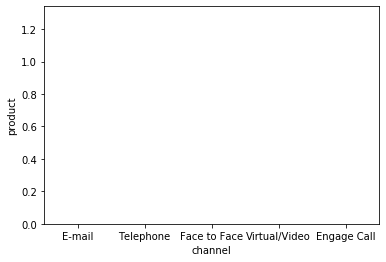

In [7]:
datainput2['channel']

0               E-mail
1                  NaN
2                  NaN
3               E-mail
4               E-mail
              ...     
168528    Face to Face
168529    Face to Face
168530       Telephone
168531    Face to Face
168532    Face to Face
Name: channel, Length: 168533, dtype: object

In [1]:
import seaborn as sns

In [ ]:
sns.barplot()

In [3]:
import pandas as pd
datainput = pd.read_csv(r"C:\Users\Ighdaro Emwinghare\Downloads\data2.csv")
datainput2 = pd.read_csv(r"C:\Users\Ighdaro Emwinghare\Downloads\data1.csv")

''' 
merge and join doesn't work correctly since there are similar columns in both datainput and datainput2. 
The correct way is to concat the two dataframes.

'''

" \nmerge and join doesn't work correctly since there are similar columns in both datainput and datainput2. \nThe correct way is to concat the two dataframes.\n\n"

In [301]:
data = pd.concat([datainput2, datainput])

In [305]:
describe(data=data, name='', date_cols=['period_week','period_month', 'date'], show_categories=False, plot_missing=False, target='product')

First five data points


,product_id,call_id,calls_account_id,date,channel,is_clm,activity_channel,key_message_id,content_category,content_message_local,...,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat,id_mail_template,id_approved_email,email_activity_event_type,email_activity_sent_email
0,a001t00000JKjL4AAL,a045J000002aHbrQAE,0011t00000IBwKeAAL,5/6/2020,E-mail,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,B3@Rheum_Science_First_Green,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
1,a001t00000JKjL4AAL,a041t00000OTN0RAAX,0011t00000IBwKeAAL,3/11/2020,NaN,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,B3@Rheum_Science_First_Green,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
2,a001t00000JKjL4AAL,a041t00000M6rqaAAB,0011t00000IBwKeAAL,1/14/2020,NaN,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,B3@Rheum_Science_First_Green,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
3,a001t00000JKjL4AAL,a045J000003Lr7JQAS,0011t00000IBwKeAAL,5/14/2020,E-mail,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,B3@Rheum_Science_First_Green,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
4,a001t00000JKjL4AAL,a045J000002Y5coQAC,0011t00000IBwKeAAL,4/27/2020,E-mail,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,B3@Rheum_Science_First_Green,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN




Random five data points


,product_id,call_id,calls_account_id,date,channel,is_clm,activity_channel,key_message_id,content_category,content_message_local,...,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat,id_mail_template,id_approved_email,email_activity_event_type,email_activity_sent_email
83792,a001t00000JKjL4AAL,a045J000003LeMXQA0,0011t00000IBxmoAAD,5/12/2020,E-mail,0.0,NaN,NaN,NaN,NaN,...,RUS,RU,EEME&A,EEMEA,A3@Rheum_Trust_First_Yellow,(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
102122,a001t00000JKjL4AAL,a045J000001KK5mQAG,0016F00001g2OgsQAE,3/10/2020,NaN,1.0,NaN,a0D1t000005j916EAA,NaN,NaN,...,AUS,AU,JAPAC,JAPAC,(No segment)@(No segment),(No message)@(No message)@(No message),NaN,NaN,NaN,NaN
56480,a001v00002KP02YAAT,a041v00001BQzbcAAD,001G000001t4w0TIAQ,2/6/2020,Face to Face,1.0,NaN,a0D1v00000NqhvhEAB,Efficacy,RINVOQ+MTX erstmals signifikant hoehere Remiss...,...,DEU,DE,WE&C,WEC,B3@(No segment),Efficacy@Remission rates vs placebo + MTX and ...,NaN,NaN,NaN,NaN
93831,a001v00002KP02YAAT,a041v00001H7pR5AAJ,001G000001VH9OgIAL,5/27/2020,Engage Call,1.0,NaN,a0D1v00000NrjsHEAR,Efficacy,"ACR50, dolore, e HAQ-DI vs ADA + MTX alla sett...",...,ITA,IT,WE&C,WEC,(No segment)@(No segment),"Efficacy@ACR50, pain, and HAQ-DI vs ADA + MTX@...",NaN,NaN,NaN,NaN
10595,a001v00002W6XH7AAN,a041v00001EOFxqAAH,001G000001t4uXgIAI,3/24/2020,Telephone,0.0,NaN,NaN,NaN,NaN,...,DEU,DE,WE&C,WEC,(No segment)@(No segment),(No message)@(No message)@(No message),NaN,NaN,NaN,NaN




Last five data points


,product_id,call_id,calls_account_id,date,channel,is_clm,activity_channel,key_message_id,content_category,content_message_local,...,ISO3,ISO,areaAbbvie,geo_area,segment_concat,content_message_concat,id_mail_template,id_approved_email,email_activity_event_type,email_activity_sent_email
58261,a001v00002W5LyvAAF,NaN,NaN,2020-01-23T17:32:46.000Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a211v000003aNlWAAU,a2Q1v000007iFCxEAM,Opened_vod,a2Q1v000007iFCxEAM
58262,a001v00002W5LyvAAF,NaN,NaN,2020-01-23T17:32:46.000Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a211v000003aNlWAAU,a2Q1v000007iFCxEAM,Opened_vod,a2Q1v000007iFCxEAM
58263,a001v00002W5LyvAAF,NaN,NaN,2020-01-23T17:32:46.000Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a211v000003aNlWAAU,a2Q1v000007iFCxEAM,Opened_vod,a2Q1v000007iFCxEAM
58264,a001v00002W5LyvAAF,NaN,NaN,2020-01-23T17:32:46.000Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a211v000003aNlWAAU,a2Q1v000007iFCxEAM,Opened_vod,a2Q1v000007iFCxEAM
58265,a001v00002W5LyvAAF,NaN,NaN,2020-01-23T17:32:46.000Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a211v000003aNlWAAU,a2Q1v000007iFCxEAM,Opened_vod,a2Q1v000007iFCxEAM




Shape of  data set: (226799, 39)


Size of  data set: 8845161


Data Types
Note: All Non-numerical features are identified as objects in pandas


,Data Type
product_id,object
call_id,object
calls_account_id,object
date,object
channel,object
is_clm,float64
activity_channel,float64
key_message_id,object
content_category,object
content_message_local,object




Numerical Features in Data set
['is_clm', 'activity_channel']


Categorical Features in Data set


['product_id',
 'call_id',
 'calls_account_id',
 'date',
 'channel',
 'key_message_id',
 'content_category',
 'content_message_local',
 'local_key_message_vault_id',
 'content_message_global',
 'global_key_message_vault_id',
 'id',
 'call_date',
 'product',
 'indication',
 'therapeutic_area',
 'fs_product_id',
 'account_id',
 'segment_quant',
 'segment_qual',
 'change_clm',
 'touchpoint_channel_clm',
 'measure_source',
 'period_week',
 'period_month',
 'con_size',
 'geo_country',
 'ISO3',
 'ISO',
 'areaAbbvie',
 'geo_area',
 'segment_concat',
 'content_message_concat',
 'id_mail_template',
 'id_approved_email',
 'email_activity_event_type',
 'email_activity_sent_email']



Statistical Description of Columns


,is_clm,activity_channel
count,168533.000000,0.0
mean,0.613138,NaN
std,0.487033,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN
max,1.000000,NaN




Description of Categorical Features


,count,unique,top,freq
product_id,226799,4,a001v00002KP02YAAT,148738
call_id,168533,71885,a045J000002aVQuQAM,286
calls_account_id,166859,14790,0016F00001lcQ4KQAU,359
date,226634,13397,3/4/2020,2924
channel,159635,5,Face to Face,104271
key_message_id,125150,1258,a0D1v00000NqhvhEAB,7256
content_category,141816,8,Efficacy,63655
content_message_local,141819,125,RINVOQ+MTX erstmals signifikant hoehere Remiss...,18491
local_key_message_vault_id,141819,170,V1N000000000501,18491
content_message_global,141819,17,Remission rates vs placebo + MTX and ADA +MTX,43217




Unique class Count of Categorical features


,Feature,Unique Count
0,product_id,4
1,call_id,71886
2,calls_account_id,14791
3,date,13398
4,channel,6
5,key_message_id,1259
6,content_category,9
7,content_message_local,126
8,local_key_message_vault_id,171
9,content_message_global,18




Missing Values in Data


,features,missing_counts,missing_percent
0,product_id,0,0.0
1,call_id,58266,25.7
2,calls_account_id,59940,26.4
3,date,165,0.1
4,channel,67164,29.6
5,is_clm,58266,25.7
6,activity_channel,226799,100.0
7,key_message_id,101649,44.8
8,content_category,84983,37.5
9,content_message_local,84980,37.5




Pearson Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Kendall Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Spearman Correlation
                  is_clm  activity_channel
is_clm               1.0               NaN
activity_channel     NaN               NaN


Bivariant Stats between categorical features
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Number of unique values too large
Frequency table
product                      ABC_Rinvoq_Rheum  Rinvoq_RA  Rinvoq_RA_KAM
glo

Frequency table
product                      ABC_Rinvoq_Rheum  Rinvoq_RA  Rinvoq_RA_KAM
global_key_message_vault_id                                            
V1M000000000101                           707      42505              5
V1M000000000102                            19      10378              3
V1M000000000103                           135       9724              4
V1M000000000104                           172      19962              3
V1M000000000105                           904       5225              3
V1M000000000201                           386      50944              0
V1M000000000303                             0         32              0
V1M000000000305                             0          9              0
V1M000000000306                             0        453              0
V1M000000000401                             0        107              0
V1M000000000402                             0        132              0
V1M000000000403                             0   

In [306]:
feature_processing(data=data, target='product', date_cols=['period_week','period_month', 'date'], percent = 70)

Dropped ['activity_channel', 'indication', 'therapeutic_area', 'con_size']
Dropped ['id_mail_template', 'id_approved_email', 'email_activity_event_type', 'email_activity_sent_email']


C:\Users\Ighdaro Emwinghare\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ighdaro Emwinghare\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Ighdaro Emwinghare\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

Pearson Correlation
product_id_0                  -0.599403
product_id_1                   0.233059
product_id_2                   0.293068
call_id                        0.069786
calls_account_id              -0.083363
channel_0                           NaN
channel_1                     -0.021320
channel_2                      0.045807
channel_3                     -0.066634
is_clm_0                            NaN
is_clm_1                       0.081659
is_clm_2                       0.068814
key_message_id                -0.047309
content_category              -0.060098
content_message_local          0.040966
local_key_message_vault_id    -0.069982
content_message_global         0.094306
global_key_message_vault_id    0.103402
id                            -0.111656
call_date                     -0.068452
product_0                           NaN
product_1                      0.318259
product_2                     -0.817656
fs_product_id_0                0.034225
fs_product_id_1     

,product_id_0,product_id_1,product_id_2,call_id,calls_account_id,channel_0,channel_1,channel_2,channel_3,is_clm_0,...,dayweek_period_week,month_period_month,year_period_month,day_period_month,dayweek_period_month,month_date,year_date,day_date,dayweek_date,product
0,0,0,1,66359,525,0,0,0,1,0,...,0,5,2020,1,4,5,2020,6,2,1
1,0,0,1,2518,525,0,0,1,0,0,...,0,3,2020,1,6,3,2020,11,2,1
2,0,0,1,251,525,0,0,1,0,0,...,0,1,2020,1,2,1,2020,14,1,1
3,0,0,1,67760,525,0,0,0,1,0,...,0,5,2020,1,4,5,2020,14,3,1
4,0,0,1,64512,525,0,0,0,1,0,...,0,4,2020,1,2,4,2020,27,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58261,0,1,1,66592,4919,0,0,1,0,0,...,0,1,2020,1,2,1,2020,23,3,2
58262,0,1,1,66592,4919,0,0,1,0,0,...,0,1,2020,1,2,1,2020,23,3,2
58263,0,1,1,66592,4919,0,0,1,0,0,...,0,1,2020,1,2,1,2020,23,3,2
58264,0,1,1,66592,4919,0,0,1,0,0,...,0,1,2020,1,2,1,2020,23,3,2
